# Technical Assignment - IKEA DA

Prepared by **Michael Zhang** | 2021 Mar | @AMSTERDAM

## 0. Executive Summary

### Question 1: Propose a segmentation analysis

Seg A, B, C

### Question 3: Key segment(s) to focus to increase sales

Seg A
based on A, B, C reasons
* Increase sales is more of a short-term goal -> with the info I have, either focus on the large seg with potential to upsell (small improvement but big moneytory potential), or niche seg with great %growth potential

### Question 2: Potential data points to improve the analysis

* Unit info: understand if the product is of high unit price (which may not be purchased again in a short term)
* Category info: similar to above; also make it difficult to interpret the clustering
* Transactional info: what does it buy together per order -> basket analysis, frequency analysis, recency (3D of CLV or CV)


### Question 4: Prediction of the value in "HaveChildren" with vitualization

## 1. Data Import, Exploration and Basic Cleaning

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
# from sklearn-extras
# from sk-learn-extra

In [3]:
# df = pd.read_csv('RetailCustomerSales.csv',sep = ';', dtype = {'CustomerID':'category',
#                                                                'ItemID':'category',
#                                                                'Sex':'category',
#                                                                'Age':'category',
#                                                                'Profession':'category',
#                                                                'CityType':'category',
#                                                                'YearsInCity':'category',
#                                                                'HaveChildren':'category',
#                                                                'ItemCategory1':'category',
#                                                                'ItemCategory2':'category',
#                                                                'ItemCategory3':'category'})

df = pd.read_csv('RetailCustomerSales.csv',sep = ';', dtype = {'CustomerID':'str',
                                                               'ItemID':'str',
                                                               'Sex':'str',
                                                               'Age':'str',
                                                               'Profession':'str',
                                                               'CityType':'str',
                                                               'YearsInCity':'str',
                                                               'HaveChildren':'str',
                                                               'ItemCategory1':'str',
                                                               'ItemCategory2':'str',
                                                               'ItemCategory3':'str'})

In [4]:
display(df)

,CustomerID,ItemID,Sex,Age,Profession,CityType,YearsInCity,HaveChildren,ItemCategory1,ItemCategory2,ItemCategory3,Amount
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6,14,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
...,...,...,...,...,...,...,...,...,...,...,...,...
537572,1004737,P00193542,M,36-45,16,C,1,0,1,2,NaN,11664
537573,1004737,P00111142,M,36-45,16,C,1,0,1,15,16,19196
537574,1004737,P00345942,M,36-45,16,C,1,0,8,15,NaN,8043
537575,1004737,P00285842,M,36-45,16,C,1,0,5,NaN,NaN,7172


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   CustomerID     537577 non-null  object
 1   ItemID         537577 non-null  object
 2   Sex            537577 non-null  object
 3   Age            537577 non-null  object
 4   Profession     537577 non-null  object
 5   CityType       537577 non-null  object
 6   YearsInCity    537577 non-null  object
 7   HaveChildren   517407 non-null  object
 8   ItemCategory1  537577 non-null  object
 9   ItemCategory2  370591 non-null  object
 10  ItemCategory3  164278 non-null  object
 11  Amount         537577 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 49.2+ MB


In [6]:
df.describe()

,Amount
count,537577.000000
mean,9333.859853
std,4981.022133
min,185.000000
25%,5866.000000
50%,8062.000000
75%,12073.000000
max,23961.000000


In [7]:
# len(df['CustomerID'].unique())
consumer_item = df.groupby('CustomerID')['ItemID'].nunique().sort_values()
print(consumer_item)

CustomerID
1000708       5
1005391       6
1004991       6
1005810       6
1002111       6
           ... 
1000889     822
1001181     861
1001941     898
1004277     978
1001680    1025
Name: ItemID, Length: 5891, dtype: int64


In [8]:
# len(df['CustomerID'].unique())
consumer_spend = df.groupby('CustomerID')['Amount'].sum().sort_values()
print(consumer_spend)

#plot: check outliers

CustomerID
1004991       44108
1005117       44432
1005012       45551
1005944       46070
1004464       46091
             ...   
1000424     6573609
1001941     6817493
1002909     7577505
1001680     8699232
1004277    10536783
Name: Amount, Length: 5891, dtype: int64


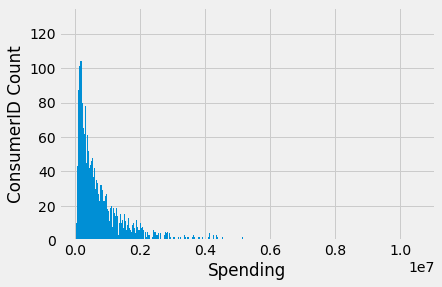

In [9]:
#plot: check potential outliers and distribution
plt.style.use("fivethirtyeight")
plt.hist(consumer_spend, bins = 1000)
plt.xlabel("Spending")
plt.ylabel("ConsumerID Count")
plt.show()

In [10]:
consumer_spend.describe()

count    5.891000e+03
mean     8.517515e+05
std      9.329978e+05
min      4.410800e+04
25%      2.349140e+05
50%      5.126120e+05
75%      1.099005e+06
max      1.053678e+07
Name: Amount, dtype: float64

**Based on above chart, turn spending per consumer into log scale skew to positive side (check the ref)**

In [11]:
# len(df['ItemID'].unique())
item_consumer = df.groupby('ItemID')['CustomerID'].nunique().sort_values()
print(item_consumer)

ItemID
P00056542       1
P00013442       1
P00013542       1
P00013842       1
P00206542       1
             ... 
P00057642    1430
P00112142    1539
P00025442    1586
P00110742    1591
P00265242    1858
Name: CustomerID, Length: 3623, dtype: int64


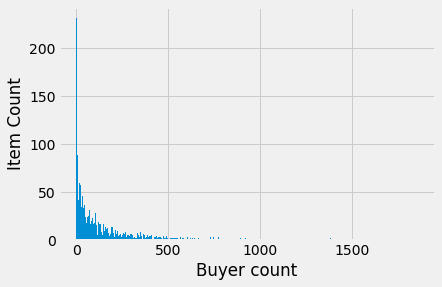

In [12]:
#plot popular product and check distribution
plt.style.use("fivethirtyeight")
plt.hist(item_consumer, bins = 1000)
plt.xlabel("Buyer count")
plt.ylabel("Item Count")
plt.show()

In [13]:
item_consumer.describe()

count    3623.000000
mean      148.378968
std       208.176730
min         1.000000
25%        19.000000
50%        70.000000
75%       192.000000
max      1858.000000
Name: CustomerID, dtype: float64

In [14]:
# len(df['ItemID'].unique())
item_sales = df.groupby('ItemID')['Amount'].sum().sort_values()
print(item_sales)

#plot high sales value

ItemID
P00091742         405
P00309042         726
P00353042        1545
P00325342        1656
P00012942        1717
               ...   
P00059442    23948299
P00184942    24060871
P00255842    24652442
P00110742    26382569
P00025442    27532426
Name: Amount, Length: 3623, dtype: int64


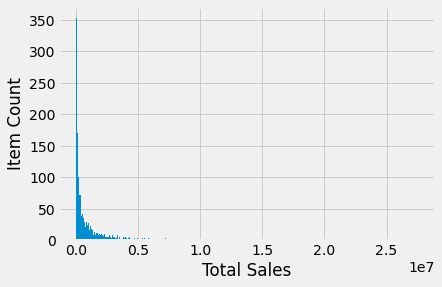

In [15]:
#plot high total sales value and check distribution
plt.style.use("fivethirtyeight")
plt.hist(item_sales, bins = 1000)
plt.xlabel("Total Sales")
plt.ylabel("Item Count")
plt.show()

In [16]:
item_sales.describe()

count    3.623000e+03
mean     1.384948e+06
std      2.608237e+06
min      4.050000e+02
25%      1.143055e+05
50%      4.352640e+05
75%      1.503716e+06
max      2.753243e+07
Name: Amount, dtype: float64

In [17]:
# df['Sex'].unique()
sex = df.groupby('Sex')['CustomerID'].nunique().sort_index()
print(sex)

Sex
F    1666
M    4225
Name: CustomerID, dtype: int64


In [18]:
# pd.Series(list(df['Age'].unique().astype('str'))).sort_values() # as category
# df['Sex'].unique()
age = df.groupby('Age')['CustomerID'].nunique().sort_index()
print(age)

Age
0-17      218
18-25    1069
26-35    2053
36-45    1167
46-50     531
51-55     481
55+       372
Name: CustomerID, dtype: int64


In [19]:
# df['CityType'].unique()
CityType = df.groupby('CityType')['CustomerID'].nunique().sort_index()
print(CityType)

CityType
A    1045
B    1707
C    3139
Name: CustomerID, dtype: int64


In [20]:
# df['YearsInCity'].unique() # as category
# YearsInCity = df['YearsInCity'].unique()
# print(np.sort(YearsInCity))
YearsInCity = df.groupby('YearsInCity')['CustomerID'].nunique().sort_index()
print(YearsInCity)

YearsInCity
0      772
1     2086
2     1145
3      979
4+     909
Name: CustomerID, dtype: int64


In [21]:
# pd.Series(list(df['Profession'].unique().astype('int'))).sort_values() # as category
# Profession = df['Profession'].nunique()
# print(np.sort(Profession))
Profession = df.groupby('Profession')['CustomerID'].nunique().sort_index()
print(Profession)

Profession
0     688
1     517
10    192
11    128
12    376
13    140
14    294
15    140
16    235
17    491
18     67
19     71
2     256
20    273
3     170
4     740
5     111
6     228
7     669
8      17
9      88
Name: CustomerID, dtype: int64


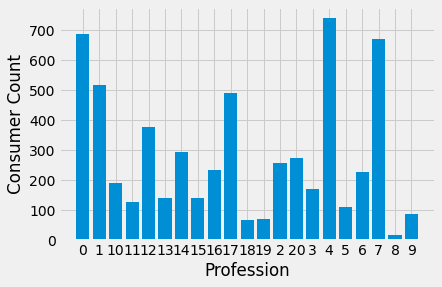

In [22]:
#plt to see if there is significant inbalanced value
plt.style.use("fivethirtyeight")
plt.bar(Profession.index,Profession)
plt.xlabel("Profession")
plt.ylabel("Consumer Count")
plt.show()

**Based on above chart, one-hot coding may skew heavily to the rare professions sucha as 8, 18, and 19. May consider use k-prototype/k-mode to avoid such issue**

In [23]:
# df['HaveChildren'].unique()
# df.loc[df['HaveChildren'].isnull(),'CustomerID'].nunique()
HaveChildren = df.groupby('HaveChildren',dropna=False)['CustomerID'].nunique().sort_index()
print(HaveChildren)

HaveChildren
0      3280
1      2399
NaN     212
Name: CustomerID, dtype: int64


**212 consumers are without Children info. Will need to run clustering twice - with and without NaN**

In [24]:
# df['ItemCategory1'].unique()
ItemCategory1 = df.groupby('ItemCategory1',dropna=False)['ItemID'].nunique().sort_values()
print(ItemCategory1)

ItemCategory1
9        2
17      11
12      25
10      25
18      30
13      35
14      44
15      44
4       88
3       90
16      98
7      102
6      119
2      152
11     254
1      491
5      966
8     1047
Name: ItemID, dtype: int64


In [25]:
# df['ItemCategory2'].unique()
ItemCategory2 = df.groupby('ItemCategory2',dropna=False)['ItemID'].nunique().sort_values()
print(ItemCategory2)

ItemCategory2
7         4
3        12
10       14
18       18
9        20
12       45
13       51
6        60
11       70
17       76
2       127
5       128
15      138
4       146
16      221
14      317
8       353
NaN    1823
Name: ItemID, dtype: int64


In [26]:
# df['ItemCategory3'].unique()
ItemCategory3 = df.groupby('ItemCategory3',dropna=False)['ItemID'].nunique().sort_values()
print(ItemCategory3)

ItemCategory3
3         3
10        5
11        6
18       14
4        14
6        14
13       16
12       31
8        37
9        37
17       42
5        43
15       69
14       80
16      115
NaN    3097
Name: ItemID, dtype: int64


In [27]:
df.loc[df['ItemCategory1'] == df['ItemCategory2'],'ItemID'].unique()

array([], dtype=object)

In [28]:
ItemCombo = df.groupby(['ItemCategory1','ItemCategory2','ItemCategory3'],
                       dropna=False)['ItemID'].nunique().sort_values()
print(ItemCombo)

ItemCategory1  ItemCategory2  ItemCategory3
9              NaN            NaN                1
5              8              12                 1
               6              9                  1
1              8              9                  1
                              18                 1
                                              ... 
5              14             NaN              136
               8              NaN              150
11             NaN            NaN              171
5              NaN            NaN              488
8              NaN            NaN              727
Name: ItemID, Length: 235, dtype: int64


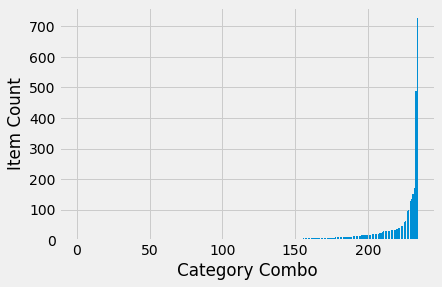

In [29]:
#plt to see how inbalanced it will be if converted to one hot encoded
ItemCombo_reindex = ItemCombo.reset_index()
plt.style.use("fivethirtyeight")
plt.bar(ItemCombo_reindex.index,ItemCombo_reindex.ItemID)
plt.xlabel("Category Combo")
plt.ylabel("Item Count")
plt.show()

In [31]:
ItemComboSales = df.groupby(['ItemCategory1','ItemCategory2','ItemCategory3'],
                       dropna=False)['Amount'].sum().sort_values()
print(ItemComboSales)

ItemCategory1  ItemCategory2  ItemCategory3
5              10             16                    7218
9              NaN            NaN                  18456
10             11             NaN                  19206
4              9              NaN                  29149
8              14             18                  117448
                                                 ...    
5              8              NaN              149089678
1              2              15               191990411
               16             NaN              198147606
5              NaN            NaN              383126455
8              NaN            NaN              449437193
Name: Amount, Length: 235, dtype: int64


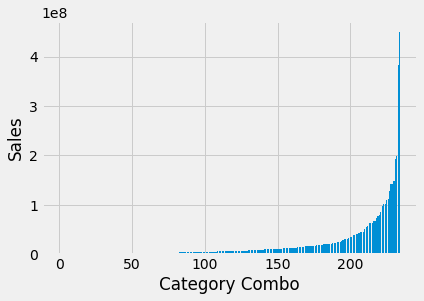

In [33]:
#plt to see how inbalanced it will be if converted to one hot encoded
ItemComboSales_reindex = ItemComboSales.reset_index()
plt.style.use("fivethirtyeight")
plt.bar(ItemComboSales_reindex.index,ItemComboSales_reindex.Amount)
plt.xlabel("Category Combo")
plt.ylabel("Sales")
plt.show()

**Either convert to 18 categories with overlaps (double count if one item falls to more than one category or use the 235 category combinations; run them with and without such. With 235 combo, also need to be logged**

## 2. Segmentation

Some options I have/decisions I have to make:
1. If there is an outlier -> looks like the data is quite clean
2. To standardize or not (for cat amount and the total amount)  
(Ref: https://pbpython.com/categorical-encoding.html  
 Ref: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02) using mapping and replace  
CustomerID -> group by  
ItemID -> drop  
Sex -> to -1 and 1; group by  
Age -> take the medium and rescale (0-17 as 17; 55+ as 55)/already encoded just rescale?  
Profession -> already encoded?  
CityType -> already encoded? 
YearsInCity -> convert to numbers (4+ as 4); group by  
HaveChildren -> to -1(N), 0 (NULL) and 1(Y); group by   
18 Category  
or 235 cateogires -> both take log and rescale  
Amount -> tke the log and rescale  
3. 18 main cat (with amount overlap and also corelation between cats) or 200+ combo cat
4. can I use k-means++ to set the centroid
5. k-means, k-prototype, k-mode/medroid
6. what evaluation metrics to use: EC, explanationary, SW

In [ ]:
## K-means
## Ref: https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means
## Ref: https://realpython.com/k-means-clustering-python/

## PAM (Partitioning Around Medoids)
## Ref: https://towardsdatascience.com/clustering-datasets-having-both-numerical-and-categorical-variables-ed91cdca0677

In [ ]:
features, true_labels = make_blobs(
    n_samples=200,
    centers=3,
    cluster_std=2.75,
    random_state=42
)

In [ ]:
features[:5]

In [ ]:
true_labels[:5]

#### Scale the features

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
scaled_features[:5]

#### Set the parameter of K-means clustering

In [1]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

NameError: name 'KMeans' is not defined

In [ ]:
kmeans.fit(scaled_features)

#### Result

In [ ]:
# The lowest SSE value
kmeans.inertia_

In [ ]:
# Final locations of the centroid
kmeans.cluster_centers_

In [ ]:
# The number of iterations required to converge
kmeans.n_iter_

In [ ]:
kmeans.labels_[:5]

#### Evaluation - SSE

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

In [ ]:
## Determine the elbow from plot
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
## Determine the elbow programmatically
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

#### Evaluation - silhouette coefficients

In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

In [ ]:
## Determine the max(sc) from plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()